# Module 4 Lab 3 - Convolutional Neural Network for image classification

## **NOTE: You need to use the Tensorflow CPU container for this notebook**
(It may take a while for this container to start and for your notebook to connect to a kernel, so be patient)

In this lab we will train a Convolutional Neural Network (CNN) to classify images as positive or negative for brain tumor.

We are installing and using Keras version 2.3.1 which is compatible with Tensforflow 1.x.  Keras is an abstraction layer on top of the tensorflow backend that presents higher level layers to work with, rather than building out a tensor flow manually.

Please watch the video from JAMA to refresh your memory on how a CNN works, linked from this module's Schedule.ipynb.

An in-depth course on neural networks, including CNN's, would take more time than we have in this course, so don't worry too much if you don't fully grasp the fundamentals of the CNN we build below.  Having exposure to it and being able to make simple changes to the network design is all that is required for this course.

The labeled image data was provided by the [Mayo Radiology Informatics Laboratory](https://www.mayo.edu/research/labs/radiology-informatics/overview)

In [1]:
import sys
!{sys.executable} -m pip install keras==2.3.1
!{sys.executable} -m pip install --upgrade "numpy>=1.2"


Requirement already up-to-date: numpy>=1.2 in /opt/conda/lib/python3.7/site-packages (1.21.5)


In [2]:
import os
import numpy as np
import math
import glob
from PIL import Image
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split


Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Build the model

We will build a sequential model, which means each layer output goes into only one following layer's input.  There are no parallel layers in a sequential model.  

For each layer except the last, we use the rectified linear activation function (relu), and for the last layer we use the sigmoid.  Sigmoid (otherwise known as the logistic function) is appropriate to output for a binary classification problem such as this one (tumor or no tumor), just as it is used in other binary classification problems such as logistic regression.

The `Conv2D` layers are the layers that take small windows (kernel_size) out of each image and output filters for the next layer.
In a CNN, at each successive convolution, it is common to increase the filters, and also common to use powers of 2.

A `MaxPooling2D` layer will take the maximum value for each area defined by `pool_size`.  

The `BatchNormalization` layer normalizes the outputs such they have a mean near zero and a standard deviation near 1.

A `Dropout` layer will randomly set inputs to zero, to help with prevention of overfitting, at the rate specified. A value of 0.5 will set approximately half of the  inputs to zero.

In the first convolution layer, we specify the dimensions and color depth of our images with the parameter `input_shape`.  Near the end, we apply some `Dense` layers, which are fully connected neural network layers, in which we specify the number of outputs we want.  We eventually want to scale the output to 1, because we are classifying a binary problem: tumor or no tumor.  The last layer is then the Sigmoid activation, which converts the output of the CNN to a probability.  The Sigmoid function is the familiar "S" shaped function map that is commonly used in binary classifications.

Finally, as we compile the model, we specify a loss function.  The loss function is responsible for estimating the error of the network so that prior to the next training iteration, the network weights can be updated to attempt to minimize this loss.  For a binary classification problem, the `binary_crossentropy` function is used.  We also specify the optimizer algorithm, which is responsible for propogating changes to the network's weights back through the model.  We will use the Adaptive Moment Estimation (adam), as it is the newest and most efficient algorithm available.

This particular network was produced by the Mayo Radiology Informatics Laboratory, from which our data was sourced, but it doesn't necessarily represent the best possible model.  When training a CNN, many of the items specified at each layer can be tuned, along with the number and order of the layers.  For this lab, we will see how this model performs.  In the practice exercise, you will modify some parameters to see the effects.


In [3]:
def create_model(img_channels, img_rows, img_cols):
    # img_channels: how many color channels
    # img_rows and img_cols: the size of the image
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = 3, padding='same', input_shape=(img_channels, img_rows, img_cols)))
    model.add(Activation('relu'))

    model.add(Conv2D(16, kernel_size = 5, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size = 2, data_format='channels_first'))

    model.add(Conv2D(16, kernel_size = 3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(64, kernel_size = 5, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(64, kernel_size = 3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size = 2, data_format='channels_first'))

    model.add(Conv2D(128, kernel_size = 3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size = 2, data_format='channels_first'))
    
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer="he_normal"))
    model.add(Activation('relu'))

    model.add(Dropout(0.5)) 
    model.add(Dense(32, kernel_initializer="he_normal"))
    model.add(Activation('relu'))

    model.add(Dropout(0.5)) 
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # learning rate optimizer
    optimizer = Adadelta(lr=0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [4]:
img_rows=32
img_cols=32
img_channels=1

model = create_model(img_channels, img_rows, img_cols)


Instructions for updating:
Colocations handled automatically by placer.


## Read the training data

The data are separated into two directories, one for postive samples (a tumor exists), and one for negative.  In each directory there are a number of jpeg files of 32x32 pixels.  These images are small to speed up the training process and reduce the memory necessary to train, at the expense of information loss.  

We will load these images into numpy arrays, one for each of the classes, then join them together.  We will also create a binary classification array for the network to train against.

We perform a train/test split so we have some images to test the model against.

In [5]:
def read_image_data(filename):
    # read grayscale image data to an 2d numpy array
    image = Image.open(filename)
    image = image.getdata()
    image = np.array(image)
    return image.reshape(-1)


def image_dir_to_array(dir):
    data = [read_image_data(image) for image in glob.glob(os.path.join(dir, '*.jpg'))]
    return np.array(data)


def load_data(negative_images_path, positive_images_path):
    negatives = image_dir_to_array(negative_images_path)
    positives = image_dir_to_array(positive_images_path)
    
    X=np.vstack((negatives, positives))
    X=X.astype(np.float) / 255 # reduce colordepth normalize the image grayscale values from 0..1
    y=np.concatenate((np.zeros(len(negatives)), np.ones(len(positives))))
    
    print ('shape of X', np.shape(X)) 
    print ('scale of X', np.min(X), np.max(X))
    print ('shape of y', np.shape(y)) 
    
    return X, y


def reshape_X(X, img_channels, img_rows, img_cols):
    # reshape the data to the 4 dimensional format required by the CNN
    # the resulting shape will be (num_samples, img_channels (1 for grayscale images), img_rows, img_cols)
    return X.reshape(-1, img_channels, img_rows, img_cols)

In [6]:
negative_images_path = '../resources/cnn-images/negative_images/'
positive_images_path = '../resources/cnn-images/positive_images/'

X, y = load_data(negative_images_path, positive_images_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = reshape_X(X_train, img_channels, img_rows, img_cols)
X_test = reshape_X(X_test, img_channels, img_rows, img_cols)

shape of X (8710, 1024)
scale of X 0.0 1.0
shape of y (8710,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## Train the model

Now we will train the model using the training data.  We specify a batch size and an epoch.  The batch size represents how many images we send through the network before the network weights are changed.  For a batch size of 32, the full training data is broken up into sets of 32 and sent one at a time through the network.  After each batch, the network weights are updated, and the next batch is sent through.  Larger batch sizes are more efficient, but produce worse/slower to converge models, whereas smaller batch sizes will produce better models but take more time to train.

The number of epochs represent how many times the model will see one complete set of data.

Both of these can be tuned and will have an effect on the model.  For this lab, we are using a small number of epochs to reduce the time it takes to train.  However, this means that the model's accuracy will be unstable.  Networks weights are randomly assigned when the model is created, so it will take a fair amount of epochs for the same model to converge to a similar set of weights with successive trainings.  Also, because of the `Dropout` layers in the model, there is a random effect to the network weights that also stabilize over time.  If you were to run this notebook multiple times in succession, you would see the ROC and other metrics change because we are using a small number of epochs (for training speed).

The learning rate controls how much the network weights can change each time the weights are updated.  In this model we are using a step wise decay of the learning rate based on the epoch.  As the epoch increases, the learning rate is reduced, leading to less change in the model over time.  A static learning rate can also be used, in which case the learning rate does not change during the course of training.

### The `fit` method

We are specifying the learning rate function and a model checkpoint in the `callbacks` parameter of the `fit` method.  `callbacks` takes an array of classes that will be called at the end of each epoch, and we use that to update our learning rate with the `step_decay` function we defined, as well as using the built in `ModelCheckpoint` function.  The `ModelCheckpoint` will save our best model at the end of each epoch.  If the current model at the end of each epoch is not better than one produced in a prior epoch, then it is not saved.  This is a good habit because sometimes training can crash for any number of reasons (out of memory, power loss, etc), and you don't want to lose the current network state, especially if you've been training for many hours or even days.  The saved model can be used to instantiate a new model with those saved weights.

The `validation_split` parameter is the percentage of data to hold out as validation to be used for checking the model at each epoch to data that was not used for training.

Finally, we specify `shuffle` = True in the `fit` method, so that the training data is shuffled prior to each epoch.  This helps to ensure the model is not learning the order of the training images.

In [7]:
# learning rate schedule dynamically calculated based on the epoch
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.3
    epochs_drop = 30.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print ('learning rate', lrate)
    return lrate


In [8]:
batch_size=64
nb_epoch=5

# used to save our model at the end of each epoch
model_checkpoint = ModelCheckpoint('model.h5', verbose=1, monitor='val_loss', save_best_only=True)

# create a learning rate callback
learning_rate = LearningRateScheduler(step_decay)

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.1,
          callbacks=[model_checkpoint,learning_rate], shuffle=True)


Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 6271 samples, validate on 697 samples
Epoch 1/5
learning rate 0.01
6271/6271 [==============================] - 9s 1ms/step - loss: 1.0835 - accuracy: 0.4825 - val_loss: 0.7064 - val_accuracy: 0.2654

Epoch 00001: val_loss improved from inf to 0.70642, saving model to model.h5
Epoch 2/5
learning rate 0.01
6271/6271 [==============================] - 7s 1ms/step - loss: 0.8583 - accuracy: 0.5589 - val_loss: 0.6994 - val_accuracy: 0.3286

Epoch 00002: val_loss improved from 0.70642 to 0.69943, saving model to model.h5
Epoch 3/5
learning rate 0.01
6271/6271 [==============================] - 6s 912us/step - loss: 0.7521 - accuracy: 0.6104 - val_loss: 0.6832 - val_accuracy: 0.6026

Epoch 00003: val_loss improved from 0.69943 to 0.68320, saving model to model.h5
Epoch 4/5
learning rate 0.01
6271/6271 [==============================] - 3s 486us/step - loss: 0.7098 - accuracy: 0.6170 - val_loss: 0.6601 - val_accuracy: 0.6686

Epoch 00004: val_loss improved from 0.68320 to 0.66010, sa

We see each of the five epochs output several values:

* loss - the metric that the training of the model attempts to lower.  The conceptual difference between what was computed on the training set and what was expected.
* accuracy - the accuracy of the classification on the training set
* val_loss - same as loss, but on the validation data
* val_accuracy - same as accuracy, but on the validation data

The goal in training the network is to optimize these values.  We want to see the loss stabilize at a hopefully low level, and the accuracy also stabilize at a hopefully high level.

## Test the model
Finally, we will use the built model to test the accuracy against the test data set to get some additional metrics.  We apply the common methods used for any binary classification problem to assess the performance.

In [9]:
Y_pred = model.predict(X_test, batch_size = 32)
roc = roc_auc_score(y_test, Y_pred)
print("ROC:", round(roc, 3))

ROC: 0.705


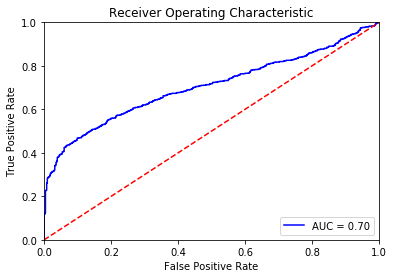

In [10]:
# create ROC plot
fpr, tpr, threshold = roc_curve(y_test, Y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
# create classification using cutoff of 0.5 probability
Y_pred[Y_pred>=.5]=1
Y_pred[Y_pred<.5]=0

target_names=[] 

print("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.")
print("The support is the number of samples of the true response that lie in that class.")
target_names = ['negative', 'positive']

print(classification_report(y_test, Y_pred, target_names=target_names, digits=4))

The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.
The support is the number of samples of the true response that lie in that class.
              precision    recall  f1-score   support

    negative     0.4355    0.3829    0.4075       538
    positive     0.7384    0.7782    0.7578      1204

    accuracy                         0.6561      1742
   macro avg     0.5869    0.5806    0.5827      1742
weighted avg     0.6448    0.6561    0.6496      1742



## Grid searching
In practice, many of the things that we can control regarding the training of our model would be modified and run in combinations in what is called a grid search.  In a grid search, different values of parameters are specified, and the combination of those paramters are all run and evaluated.  The final model is the one in which the best metric is achieved using one of the parameter set combinations.  For example, we could do a grid search with two different batch sizes (32 and 64) and two static learning rates (0.1 and 0.075).  The model would then be fit four times:

```
batch size    learning rate
32            0.1 
32            0.075 
64            0.1
64            0.075
    
```

We can use sklearn's [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with Keras models with a few extra steps.  We need to wrap our model creation function in a KerasClassifier class, which is compatible with sklearn.

The `param_grid` dictionary specifies the parameters that we wish to pass into the grid search.  Each item in the dictionary is a parameter to either the model creation function or the fit function.  They must be specified in lists, and the combination across all of those values in each list is what makes up the grid.  The parameters that we use in our model function must remain the same because they define our image size and format, but the epochs and batch we can vary.

When we call the `GridSearchCV`, the training and validation is done using Cross Validation, and we specify the number of folds in the `cv` parameter.  It's important that we pass our full dataset into this method, and not the train/test split as we have done prior.  

We also specify -1 for `n_jobs`.  This parameter controls how many jobs to run in parallel.  a value of -1 tells sklearn to use as many jobs as there are CPUs.

The `verbose=2` parameter will give us some output as the models are trained so we can track progress.

A final note regarding the callbacks:  We are not able to pass any callbacks to the Keras fitter, so the learning rate in the below example is using the default rate for the ADAM optimizer.

Running this may take a bit of time so be patient.  Also note that the grid search hides some of the verbosity we could get from running the Keras fit directly, so it may seem as though nothing is happening, but it is!

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model, verbose=2)

param_grid = {
    'img_channels': [img_channels],
    'img_rows': [img_rows],
    'img_cols': [img_cols],
    'epochs': [2],
    'batch_size': [64],
}

X = reshape_X(X, img_channels, img_rows, img_cols) # we have to reshape our input to match what the CNN expects

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv = 3, verbose=2)
grid_result = grid.fit(X, y, shuffle=True)

print("Best model: %f with parameters %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/2
 - 5s - loss: 1.8507 - accuracy: 0.3980
Epoch 2/2
 - 4s - loss: 1.8704 - accuracy: 0.3951
Best model: 0.666667 with parameters {'batch_size': 64, 'epochs': 2, 'img_channels': 1, 'img_cols': 32, 'img_rows': 32}


## Conclusion
In this lab, we built, trained, and tested a CNN that attempts to classify MRI images as having tumors or not.  The accuracy is unstable because we've used a small number of epochs.  Also, becuase the network is initialized with random weights, along with other random processes, the accuracy and ROC that you see will vary each time you run this model.  As the epochs are increased the model will become more stable, but the training will take longer.  

In the practice and the exercise, you will modify some of these parameters to see their effects on the ROC and accuracy.